In [ ]:
# Import libraries

import os
import csv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from concurrent.futures import ProcessPoolExecutor
from itertools import combinations


In [ ]:

pitch_name_to_PC = {
    "C": 0,
    "D": 2,
    "E": 4,
    "F": 5,
    "G": 7,
    "A": 9,
    "B": 11,
}


def pitch_name_to_MIDI(pitch_name: str) -> int:
    if len(pitch_name) < 2:
        raise ValueError("Invalid pitch name format")

    octave = int(pitch_name[-1])
    midi_number = (octave + 1) * 12

    pitch_step = pitch_name_to_PC.get(pitch_name[0])
    if pitch_step is None:
        raise ValueError(f"Invalid pitch step: {pitch_name[0]}")

    midi_number += pitch_step

    for char in pitch_name[1:-1]:
        if char in ["-", "b"]:
            midi_number -= 1
        elif char == "#":
            midi_number += 1
        else:
            raise ValueError("Invalid accidental in pitch name")

    return midi_number


def pitches_string_to_MIDI_list(pitches_string: str) -> list[int]:
    return [pitch_name_to_MIDI(pitch) for pitch in pitches_string.split()]


def pitches_to_iv(pitches: list[int]) -> tuple[int]:
    distinct_pitches = [p % 12 for p in pitches]
    vector = [0] * 6
    for a, b in combinations(distinct_pitches, 2):
        interval_class = abs(b - a) % 12
        interval_class = min(interval_class, 12 - interval_class)
        vector[interval_class - 1] += 1
    return tuple(vector)


def is_of_type(midi_list: list[int], cardinality: int, accepted_ivs: tuple[tuple]) -> bool:
    return len(midi_list) == cardinality and pitches_to_iv(midi_list) in accepted_ivs


def is_triad(midi_list: list[int]) -> bool:
    accepted_ivs = ((0, 0, 2, 0, 0, 1), (0, 0, 1, 1, 1, 0), (0, 0, 0, 3, 0, 0))
    return is_of_type(midi_list, 3, accepted_ivs)


def is_seventh(midi_list: list[int]) -> bool:
    accepted_ivs = (
        (1, 0, 1, 2, 2, 0),
        (0, 1, 2, 1, 2, 0),
        (0, 1, 2, 1, 1, 1),
    )
    return is_of_type(midi_list, 4, accepted_ivs)


iv_to_str = {
    (0, 0, 2, 0, 0, 1): "diminished",
    (0, 0, 1, 1, 1, 0): "triad",
    (0, 0, 0, 3, 0, 0): "augmented",
    (1, 0, 1, 2, 2, 0): "major 7th",
    (0, 1, 2, 1, 2, 0): "minor 7th",
    (0, 1, 2, 1, 1, 1): "Dom7/half-dim7",
}


In [ ]:
def is_freie_Leittoneinstellung(
    slice_1: str,
    slice_2: str,
    require_no_common_tone: bool = False,
    require_slice_1_not_common: bool = True,
    require_slice_2_common: bool = True,
    min_distinct: int = 3,
    max_step: int = 1
) -> bool:


    slice_pitches_1 = pitches_string_to_MIDI_list(slice_1)
    slice_pitches_2 = pitches_string_to_MIDI_list(slice_2)


    pcs1 = [p % 12 for p in slice_pitches_1]
    pcs2 = [p % 12 for p in slice_pitches_2]


    if min_distinct < 3:
        raise ValueError("The `min_distinct` value must be 3 or more.")

    if len(set(pcs1)) < min_distinct:
        return False


    if require_slice_1_not_common:
        if len(pcs1) == 3 and is_triad(pcs1):
            return False
        if len(pcs1) == 4 and is_seventh(pcs1):
            return False


    if require_slice_2_common:
        if len(pcs2) == 3 and not is_triad(pcs2):
            return False
        if len(pcs2) == 4 and not is_seventh(pcs2):
            return False


    if require_no_common_tone and any(p in slice_pitches_2 for p in slice_pitches_1):
        print(f"Common tones: {[p for p in slice_pitches_1 if p in slice_pitches_2]}")
        return False


    expanded = set(p + offset for p in slice_pitches_1 for offset in range(-max_step, max_step + 1))
    if not set(slice_pitches_2).issubset(expanded):
        print(f"Beyond a step of {max_step} semitones: {[p for p in slice_pitches_2 if p not in expanded]}")
        return False

    return True


In [ ]:
# Iterate 8672 files and count the slice pairs in each composer's work that 
# satisfy the function's requirements

main_folder = 'D:/YCACL-main/data/'
result_file = 'D:/YCACL-main/results.csv'

with open(result_file, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Count'])

for composer_folder in os.listdir(main_folder):
    composer_folder_path = os.path.join(main_folder, composer_folder)

    if os.path.isdir(composer_folder_path):
        for csv_file in os.listdir(composer_folder_path):
            if csv_file.endswith('.csv'):
                csv_file_path = os.path.join(composer_folder_path, csv_file)

                with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
                    csvreader = csv.reader(csvfile)
                    rows = [row for row in csvreader if len(row) > 1]

                count = 0
                for i in range(len(rows) - 1):
                    slice_1 = rows[i][1]
                    slice_2 = rows[i + 1][1]

                    try:
                        midi_number1 = pitches_string_to_MIDI_list(slice_1)
                        midi_number2 = pitches_string_to_MIDI_list(slice_2)
                    except KeyError:
                        print(f"invalid_pitch: {slice1} or {slice2}")
                        continue

                    if is_freie_Leittoneinstellung(slice_1, slice_2):
                        print(f"slice_pairs: {slice_1}, {slice_2}")
                        count += 1

                with open(result_file, 'a', newline='', encoding='utf-8') as csvfile:
                    csvwriter = csv.writer(csvfile)
                    csvwriter.writerow([csv_file, count])


In [ ]:
# Remove the redundant suffix and underscore

main_folder = 'D:/YCACL-main/data/'
result_file = 'D:/YCACL-main/results.csv'
metadata_file = 'D:/YCACL-main/YCAC-Metadata.csv'

df = pd.read_csv(result_file)

def remove_csv_suffix(filename):
    suffix = '.csv'
    if filename.endswith(suffix):
        return filename[:-len(suffix)]
    return filename

df['Filename'] = df['Filename'].apply(remove_csv_suffix)

df['Filename'] = df['Filename'].str.replace('_', ' ')

df.to_csv('counts.csv', index=False)

# Remove the redundant
df = pd.read_csv(metadata_file)

df['Genre'] = df['Genre'].str.lower()
df['Genre'] = df['Genre'].str.replace(' ', '')
df['Genre'] = df['Genre'].fillna('unknown')

df.to_csv('YCACL-metadata_new.csv', index=False)


# Save the merged csv file
df1 = pd.read_csv('counts.csv')
df2 = pd.read_csv('YCACL-metadata_new.csv')

merged_df = pd.merge(df1, df2, on='Filename', how='inner')

merged_df.to_csv('D:/YCACL-main/merged_results.csv', index=False)

In [ ]:
# Merge the date column and the range column

df = pd.read_csv('D:/YCACL-main/merged_results.csv')

def merge_date_range(row):
    date_value = row['Date']
    range_value = row['Range']

    if pd.notna(date_value) and pd.notna(range_value):
        return f"{date_value} - {range_value}"
    elif pd.notna(date_value):
        return date_value
    elif pd.notna(range_value):
        return range_value
    else:
        return None

df['merged_date'] = df.apply(merge_date_range, axis=1)

df.to_csv ('merged_results1.0.csv', index = False)


In [ ]:
# Count the number of rows in the final merged csv file

df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv' )

num_rows = df.shape[0]
print(f'Data rows: {num_rows}')

Data rows: 8432


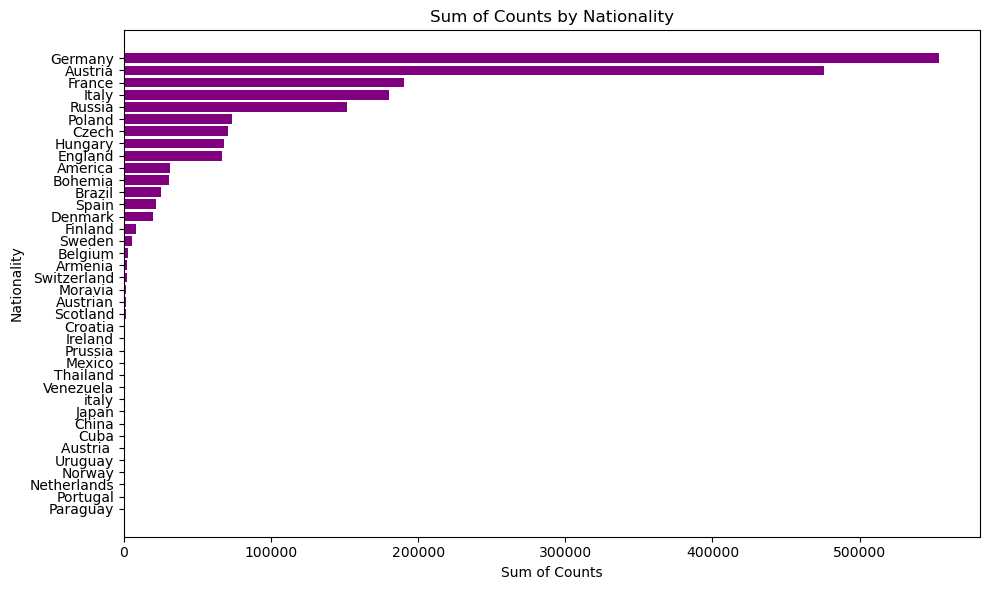

In [ ]:
# Generate charts based on this final merged CSV file containing 8432 rows of data

df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')

grouped_df = df.groupby('Nationality')['Count'].sum().reset_index()

grouped_df = grouped_df.sort_values(by='Count')

plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Nationality'], grouped_df['Count'], color='purple')
plt.xlabel('Sum of Counts')
plt.ylabel('Nationality')
plt.title('Sum of Counts by Nationality')
plt.tight_layout()
plt.show()

In [ ]:
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.globals import CurrentConfig, OnlineHostType

grouped_df = df.groupby('Nationality')['Count'].sum().reset_index()
grouped_df = grouped_df.sort_values(by='Count')

world_map = Map()

world_map.add(
    series_name="Count",
    data_pair=[(row['Nationality'], row['Count']) for _, row in grouped_df.iterrows()],
    maptype="world",
    tooltip_opts=opts.TooltipOpts(
        is_show=True,
        trigger="item",
        formatter="{b}: {c}",  
        background_color="rgba(255,255,255,0.7)",  
        border_color="#ccc",  
        border_width=1,  
        textstyle_opts=opts.TextStyleOpts(font_size=12)  
    )
)

world_map.set_global_opts(
    title_opts=opts.TitleOpts(title="Sum of Counts by Nationality"),
    visualmap_opts=opts.VisualMapOpts(max_=grouped_df['Count'].max()),  
    toolbox_opts=opts.ToolboxOpts(is_show=False)  
)

world_map.render_notebook()



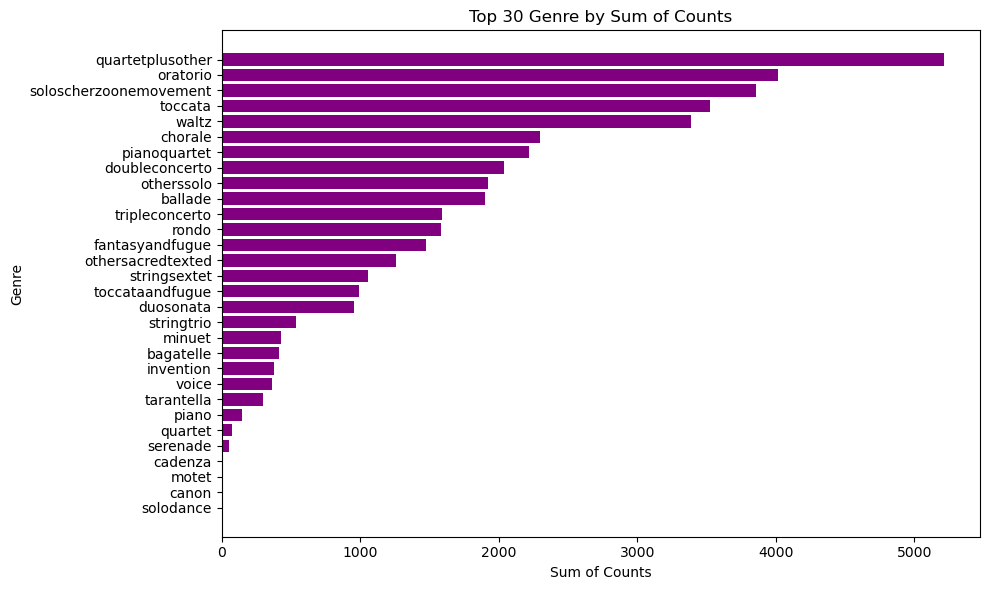

In [ ]:
df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')

grouped_df = df.groupby('Genre')['Count'].sum().reset_index()

grouped_df = grouped_df.sort_values(by='Count')

top_n = 30
grouped_df = grouped_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(grouped_df['Genre'], grouped_df['Count'], color='purple')
plt.xlabel('Sum of Counts')
plt.ylabel('Genre')
plt.title(f'Top {top_n} Genre by Sum of Counts')
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')

grouped_df = df.groupby('Composer')['Count'].sum().reset_index()

grouped_df = grouped_df.sort_values(by='Count', ascending=False).head(80)

plt.figure(figsize=(10, 12))
plt.barh(grouped_df['Composer'], grouped_df['Count'], color='purple', height=0.8)
plt.xlabel('Sum of Counts')
plt.ylabel('Composer')
plt.title('Top 80 Composers by Sum of Counts')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.axvline(25000, color='brown', linestyle='--', linewidth=1.5)
plt.axvline(50000, color='brown', linestyle='--', linewidth=1.5)
plt.axvline(75000, color='brown', linestyle='--', linewidth=1.5)
plt.axvline(100000, color='brown', linestyle='--', linewidth=1.5)
plt.show()



In [ ]:
df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')

df['Key'] = df['Key'].str.replace('Major', 'major')
df['Key'] = df['Key'].str.replace('Minor', 'minor')

grouped_df = df.groupby('Key')['Count'].sum().reset_index()

grouped_df = grouped_df.sort_values(by='Count', ascending=False).head(80)

plt.figure(figsize=(10, 12))
plt.barh(grouped_df['Key'], grouped_df['Count'], color='purple', height=0.8) 
plt.xlabel('Sum of Counts')
plt.ylabel('Key')
plt.title('Key by Sum of Counts')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

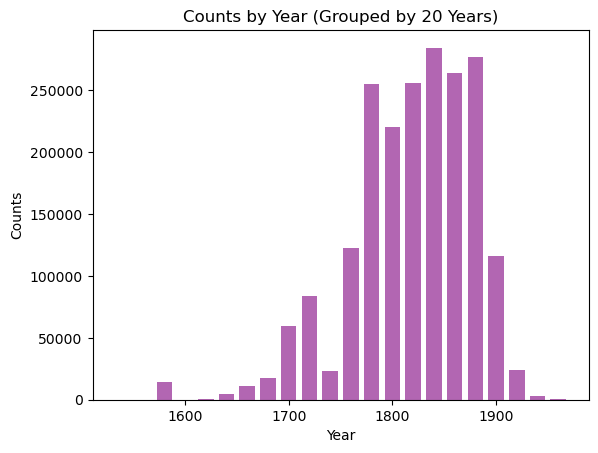

In [ ]:
# The year range data contains either date or range, and sometimes both exist at the same time.
# In addition, when performing the year conversion operation
# on this column, extra spaces, and characters such as ? are found
# in the data, which need to be cleaned up before the conversion operation.
# Then generate a chart based on the result of the picture year count

def convert_year(year):
    if pd.isna(year) or year == '' or not isinstance(year, str):
        return None
    year = year.replace(' ', '')
    if re.match(r'^\d{4}-\d{4}$', year):
        try:
            start, end = map(int, year.split('-'))
            return (start + end) // 2
        except ValueError:
            return None
    elif re.match(r'^\d{4}$', year):
        try:
            return int(year)
        except ValueError:
            return None
    else:
        return None


df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')
df['merged_date'] = df['merged_date'].apply(convert_year)

df.dropna(subset=['merged_date'], inplace=True)

df['grouped_year'] = (df['merged_date'] // 20) * 20

grouped_df = df.groupby('grouped_year')['Count'].sum().reset_index()

fig, ax1 = plt.subplots()

ax1.bar(grouped_df['grouped_year'], grouped_df['Count'], width=15, color='purple', alpha=0.6)
ax1.set_xlabel('Year')
ax1.set_ylabel('Counts')
plt.title('Counts by Year (Grouped by 20 Years)')
plt.show()


In [ ]:
# The summary chart output for above average composers shows that
# there is overlap for several composers,
# so separate charts are plotted for each year grouping.
# The complete overview is in the following section.


df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')
df['merged_date'] = df['merged_date'].apply(convert_year)
df.dropna(subset=['merged_date'], inplace=True)

# Calculation of grouping year
df['grouped_year'] = (df['merged_date'] // 20) * 20

# Calculate the total number of counts used in each subgroup year
counts_sums = df.groupby('grouped_year')['Count'].sum()

# Group by grouped_year and count the number of unique composers in each grouped year
composer_counts_per_period = df.groupby('grouped_year')['Composer'].nunique()

# Calculate the average usage in each year group
average_usage = counts_sums / composer_counts_per_period
average_usage = average_usage.rename('Count_average')

# Merge the two dataframes
composer_usage = df.groupby(['Composer', 'grouped_year'])['Count'].sum().reset_index()


composer_usage = composer_usage.merge(
    average_usage.reset_index(),
    on='grouped_year'
)

composer_usage['Ratio'] = composer_usage['Count'] / composer_usage['Count_average']

# Access to somposers wiht aboube-average usage rates
high_usage_composers = composer_usage[composer_usage['Ratio'] > 1]

# Get the unique years
grouped_years = high_usage_composers['grouped_year'].unique()

# Separate graphs for each year range
for year in sorted(grouped_years):
    subset_df = high_usage_composers[high_usage_composers['grouped_year'] == year]

    plt.figure(figsize=(12, 8))
    plt.bar(subset_df['Composer'], subset_df['Ratio'], color='teal', alpha=0.7)
    plt.xlabel('Composer')
    plt.ylabel('Usage Ratio')
    plt.title(f'Composers with Above Average Usage Ratio for {int(year)} to {int(year + 19)}')
    plt.xticks(rotation=90)
    plt.savefig(f'composers_usage_{int(year)}.png')
    plt.show()


In [ ]:
# The complete graph

df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')
df['merged_date'] = df['merged_date'].apply(convert_year)
df.dropna(subset=['merged_date'], inplace=True)


df['grouped_year'] = (df['merged_date'] // 20) * 20


counts_sums = df.groupby('grouped_year')['Count'].sum()


composer_counts_per_period = df.groupby('grouped_year')['Composer'].nunique()


average_usage = counts_sums / composer_counts_per_period
average_usage = average_usage.rename('Count_average')


composer_usage = df.groupby(['Composer', 'grouped_year'])['Count'].sum().reset_index()


composer_usage = composer_usage.merge(
    average_usage.reset_index(),
    on='grouped_year'
)
composer_usage['Ratio'] = composer_usage['Count'] / composer_usage['Count_average']


high_usage_composers = composer_usage[composer_usage['Ratio'] > 1]


plt.figure(figsize=(12, 8))
plt.bar(high_usage_composers['Composer'], high_usage_composers['Ratio'], color='teal', alpha=0.7)
plt.xlabel('Composer')
plt.ylabel('Usage Ratio')
plt.title('Composers with Above Average Usage Ratio')
plt.xticks(rotation=90)
plt.axhline(y=1, color='black', linestyle='dotted')
plt.show()




In [ ]:
# The summary chart output for above average composers shows that 
# there is overlap for several composers, 
# so separate charts are plotted for each year grouping.
# The complete overview is in the following section.


df = pd.read_csv('D:/YCACL-main/merged_results1.0.csv')
df['merged_date'] = df['merged_date'].apply(convert_year)
df.dropna(subset=['merged_date'], inplace=True)

# Calculation of grouping year
df['grouped_year'] = (df['merged_date'] // 20) * 20

# Calculate the total number of counts used in each subgroup year
counts_sums = df.groupby('grouped_year')['Count'].sum()

# Group by grouped_year and count the number of unique composers in each grouped year
composer_counts_per_period = df.groupby('grouped_year')['Composer'].nunique()

# Calculate the average usage in each year group
average_usage = counts_sums / composer_counts_per_period
average_usage = average_usage.rename('Count_average')  

# Merge the two dataframes
composer_usage = df.groupby(['Composer', 'grouped_year'])['Count'].sum().reset_index()


composer_usage = composer_usage.merge(
    average_usage.reset_index(), 
    on='grouped_year'
)

composer_usage['Ratio'] = composer_usage['Count'] / composer_usage['Count_average']

# Access to somposers wiht aboube-average usage rates
high_usage_composers = composer_usage[composer_usage['Ratio'] > 1]

# Get the unique years

from matplotlib.colors import LinearSegmentedColormap, hex2color

colors_hex = ['#0072B8', '#D5531C', '#EAB125']

colors_rgb = [hex2color(c) for c in colors_hex]

def create_gradient_colormap(color, n):
    return LinearSegmentedColormap.from_list("custom_gradient", [color, color], N=n)

grouped_years = high_usage_composers['grouped_year'].unique()

for i, year in enumerate(sorted(grouped_years)):
    subset_df = high_usage_composers[high_usage_composers['grouped_year'] == year]

    plt.figure(figsize=(16, 9))

    color_index = i % len(colors_rgb)
    color = colors_rgb[color_index]
    
    color_map = create_gradient_colormap(color, len(subset_df))
    
    colors = color_map(np.linspace(0.2, 1, len(subset_df)))  # 从浅到深的渐变效果
    
    plt.bar(subset_df['Composer'], subset_df['Ratio'], color=colors, alpha=0.7)
    plt.xlabel('Composer')
    plt.ylabel('Usage Ratio')
    plt.title(f'Composers with Above Average Usage Ratio for {int(year)} to {int(year + 19)}')
    plt.xticks(rotation=90)
    plt.axhline(y=1, color='black', linestyle='dotted')
    plt.savefig(f'composers_usage_{int(year)}.png')
    plt.show()

In [ ]:
# Store all the slice pairs that satisfy the conditions
# and the corresponding local tonic into a csv file

main_folder = '/content/drive/My Drive/data'
pairs_file = '/content/drive/My Drive/pairs.csv'

with open(pairs_file, 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Slice Pair 1', 'LocalTonic 1', 'Slice Pair 2', 'LocalTonic 2'])

for composer_folder in os.listdir(main_folder):
    composer_folder_path = os.path.join(main_folder, composer_folder)

    if os.path.isdir(composer_folder_path):
        for csv_file in os.listdir(composer_folder_path):
            if csv_file.endswith('.csv'):
                csv_file_path = os.path.join(composer_folder_path, csv_file)

                with open(csv_file_path, 'r', newline='', encoding='utf-8') as csvfile:
                    csvreader = csv.reader(csvfile)
                    rows = [row for row in csvreader if len(row) > 1]

                processed_pairs = set()
                for i in range(len(rows) - 1):
                    slice_1 = rows[i][1]
                    localtonic_1 = rows[i][2]
                    slice_2 = rows[i + 1][1]
                    localtonic_2 = rows[i + 1][2]

                    try:
                        midi_number1 = pitches_string_to_MIDI_list(slice_1)
                        midi_number2 = pitches_string_to_MIDI_list(slice_2)
                    except KeyError:
                        print(f"invalid_pitch: {slice_1} or {slice_2}")
                        continue

                    if is_freie_Leittoneinstellung(slice_1, slice_2):
                        current_pair = (slice_1, slice_2)
                        if current_pair not in processed_pairs:
                            with open(pairs_file, 'a', newline='', encoding='utf-8') as csvfile:
                                csvwriter = csv.writer(csvfile)
                                csvwriter.writerow([csv_file, slice_1, localtonic_1, slice_2, localtonic_2])
                            processed_pairs.add(current_pair)


In [ ]:
file_path = 'D:/YCACL-main/pairs.csv'

df = pd.read_csv(file_path)

num_rows = df.shape[0]
print(f'Data rows: {num_rows}')


Data rows: 1407261


In [ ]:
# In case of duplication

input_csv_file = '/content/drive/My Drive/pairs.csv'
output_csv_file = '/content/drive/My Drive/pairs_deduped.csv'

unique_rows = set()

with open(input_csv_file, 'r', newline='', encoding='utf-8') as infile:
    csvreader = csv.reader(infile)
    header = next(csvreader)
    for row in csvreader:
        unique_rows.add(tuple(row))


with open(output_csv_file, 'w', newline='', encoding='utf-8') as outfile:
    csvwriter = csv.writer(outfile)
    csvwriter.writerow(header)
    for row in unique_rows:
        csvwriter.writerow(row)


In [ ]:
# The output after deduplication is the same as the original number, which is still 1407261

file_path = '/content/drive/My Drive/pairs_deduped.csv'

df = pd.read_csv(file_path)

num_rows = df.shape[0]
print(f'Data rows: {num_rows}')


In [ ]:
# When carrying out the subsequent functions, it was found that pitches name is less than 2,
# so the slice pair 1 column was searched for based on space separation

# Finally, the problem data found is only one row,
# the filename column is a series of pitches name,
# and the slice pair has only one number 3

df = pd.read_csv('/content/drive/My Drive/pairs_deduped.csv')

column_name = 'Slice Pair 1'

def count_parts(s):
    return len(s.split())

filtered_df = df[df[column_name].apply(lambda x: count_parts(x) < 2)]

filtered_df.to_csv('filtered_output.csv', index=False)


In [ ]:
# Remove the problematic row

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/pairs_deduped.csv')

value_to_remove = 'E-3 G3 B-3'

df_cleaned = df[df['Filename'] != value_to_remove]

drive_path = '/content/drive/My Drive/cleaned_file.csv'

df_cleaned.to_csv(drive_path, index=False)


In [ ]:
# Use thenorm_progression_to_lowest function to normalize the pitches in the slice pairs
# tqdm is used to display the progress bar

from tqdm import tqdm

def norm_progression_to_lowest(pitches_string: str) -> list[int]:
    pitch_list = pitches_string_to_MIDI_list(pitches_string)
    min_val = min(pitch_list)
    return [x - min_val for x in pitch_list]

df = pd.read_csv('/content/drive/My Drive/cleaned_file.csv')

normalized_data = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Normalizing slices"):
    slice1, slice2 = row['Slice Pair 1'], row['Slice Pair 2']
    norm_slice1 = norm_progression_to_lowest(slice1)
    norm_slice2 = norm_progression_to_lowest(slice2)
    normalized_data.append([set(norm_slice1), set(norm_slice2)])

normalized_df = pd.DataFrame(normalized_data, columns=['norm_slice1', 'norm_slice2'])

normalized_df['Combined'] = normalized_df.apply(lambda row: (frozenset(row['norm_slice1']), frozenset(row['norm_slice2'])), axis=1)

counts = normalized_df['Combined'].value_counts()

duplicates = counts[counts > 1]

duplicates_data = []
for item, count in tqdm(duplicates.items(), desc="Processing duplicates"):
    norm_slice1, norm_slice2 = item
    duplicates_data.append({
        'Set': f"({sorted(list(norm_slice1))}, {sorted(list(norm_slice2))})",
        'Count': count
    })

duplicates_df = pd.DataFrame(duplicates_data)
duplicates_df.to_csv('/content/drive/My Drive/modification/duplicates.csv', index=False)


In [ ]:

num_rows = len(duplicates_df)

print(f"Duplicates: {num_rows}")

In [ ]:
df = pd.read_csv('/content/drive/My Drive/modification/duplicates.csv')


def parse_set_string(set_string):

    set_string = set_string.strip("()")
    sets = set_string.split("], [")
    list1 = list(map(int, sets[0].strip("[]").split(", ")))
    list2 = list(map(int, sets[1].strip("[]").split(", ")))
    return [list1, list2]

df['Parsed_Set'] = df['Set'].apply(parse_set_string)

df['mod_norm_set1'] = df['Parsed_Set'].apply(lambda x: frozenset([note % 12 for note in x[0]]))
df['mod_norm_set2'] = df['Parsed_Set'].apply(lambda x: frozenset([note % 12 for note in x[1]]))

df['Combined'] = df.apply(lambda row: (row['mod_norm_set1'], row['mod_norm_set2']), axis=1)

counts = df['Combined'].value_counts()

duplicates_data = []
for item, count in tqdm(counts.items(), desc="Processing combined results"):
    mod_norm_set1, mod_norm_set2 = item
    duplicates_data.append({
        'Modulo_Set': f"({sorted(list(mod_norm_set1))}, {sorted(list(mod_norm_set2))})",
        'Count': count
    })

final_duplicates_df = pd.DataFrame(duplicates_data)
final_duplicates_df.to_csv('/content/drive/My Drive/modification/modulo_duplicates_combined.csv', index=False)


In [ ]:
# The number of rows is 8783
num_rows = len(final_duplicates_df)

print(f"Duplicates: {num_rows}")

In [ ]:
final_duplicates_df = pd.read_csv('/content/drive/My Drive/modification/modulo_duplicates_combined.csv')


def compare_sets(set_pair):

    set1, set2 = ast.literal_eval(set_pair)
    set1 = set(set1)
    set2 = set(set2)


    if set1 == set2:
        return 'Equal'
    elif set1.issubset(set2):
        return 'Subset'
    elif set1.issuperset(set2):
        return 'Superset'
    elif set1 & set2:
        return 'Intersect'
    else:
        return 'Disjoint'


final_duplicates_df['Relation'] = final_duplicates_df['Modulo_Set'].apply(compare_sets)


relation_summary = final_duplicates_df.groupby('Relation')['Count'].sum().reset_index()

relation_summary.to_csv('/content/drive/My Drive/modification/relation_summary.csv', index=False)

print(relation_summary)


In [ ]:
intersect_sets_top20 = final_duplicates_df[final_duplicates_df['Relation'] == 'Intersect'].head(20)

print(intersect_sets_top20[['Modulo_Set', 'Count']])



In [ ]:
superset_sets_top20 = final_duplicates_df[final_duplicates_df['Relation'] == 'Superset'].head(20)

print(superset_sets_top20[['Modulo_Set', 'Count']])

In [ ]:
subset_sets_top20 = final_duplicates_df[final_duplicates_df['Relation'] == 'Subset'].head(20)

print(subset_sets_top20[['Modulo_Set', 'Count']])

In [ ]:
# Number of rows where only slice1 and slice2 are the same: 3588
# Number of rows where both slice1, slice2 and local tonic1, 
# local tonic2 are the same: 117489

df = pd.read_csv('/content/drive/My Drive/cleaned_file.csv')

only_slice_same_count = 0
slice_and_tonic_same_count = 0


for index, row in df.iterrows():
    slice1 = row['Slice Pair 1']
    slice2 = row['Slice Pair 2']
    tonic1 = row['LocalTonic 1']
    tonic2 = row['LocalTonic 2']

    if slice1 == slice2 and tonic1 != tonic2:
        only_slice_same_count += 1

    if slice1 == slice2 and tonic1 == tonic2:
        slice_and_tonic_same_count += 1


print("Number of rows where only slice1 and slice2 are the same:", only_slice_same_count)
print("Number of rows where both slice1, slice2 and local tonic1, local tonic2 are the same:", slice_and_tonic_same_count)